In [1]:
import numpy as np
import numpy.ma as ma # for masked arrays

%matplotlib inline
import matplotlib.pyplot as plt

from netCDF4 import Dataset

In [2]:

#########################

ncfile = 'Atlantic_for_turb.nc'
ncfile = 'GS_for_turb.nc'

#########################

with Dataset(ncfile) as nc:
    u = nc.variables['us'][0,:,:].T
    v = nc.variables['vs'][0,:,:].T


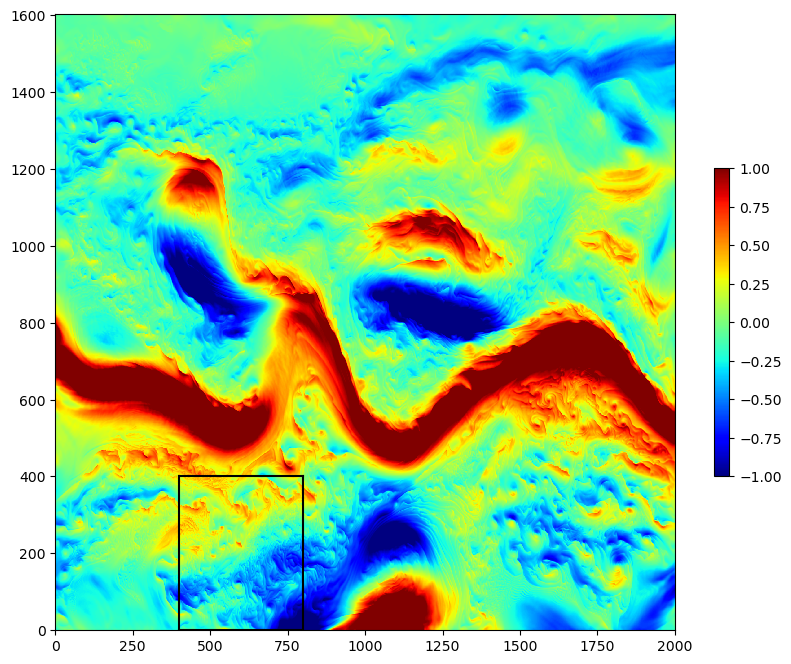

In [10]:
###########################

def u2rho(var_u):

    [M,Lp]=var_u.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[1:M,:]=0.5*(var_u[0:Mm,:]+var_u[1:M,:])
    var_rho[0,:]=var_rho[1,:]
    var_rho[Mp-1,:]=var_rho[M-1,:]

    return var_rho

############################

def v2rho(var_v):

    [Mp,L]=var_v.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[:,1:L]=0.5*(var_v[:,0:Lm]+var_v[:,1:L])
    var_rho[:,0]=var_rho[:,1]
    var_rho[:,Lp-1]=var_rho[:,L-1]
    return var_rho

############################

if 'Atlantic' in ncfile: # for the Atlantic domain
    zoom = [500,1000,1050,1550]
elif 'GS' in ncfile:
    #full domain
    zoom = [100,1500,100,1500]
    #region with submesoscale
    zoom = [400,800,0,400]

############################
    
uzoom = u2rho(u)[zoom[0]:zoom[1],zoom[2]:zoom[3]]
vzoom = v2rho(v)[zoom[0]:zoom[1],zoom[2]:zoom[3]]
    
############################

fig=plt.figure(figsize=(10.,8.))

ax1 = fig.add_subplot(111,facecolor='Gainsboro')     
CS1 = ax1.pcolormesh(ma.masked_invalid(u.T), cmap=plt.get_cmap('jet'),vmin=-1.,vmax=1.,rasterized=True)

plt.plot([zoom[0],zoom[1]],[zoom[2],zoom[2]],'-k')
plt.plot([zoom[0],zoom[1]],[zoom[3],zoom[3]],'-k')
plt.plot([zoom[0],zoom[0]],[zoom[2],zoom[3]],'-k')
plt.plot([zoom[1],zoom[1]],[zoom[2],zoom[3]],'-k')


plt.colorbar(CS1,shrink=0.5);
ax1.axis('tight'); 



Text(0, 0.5, 'P.S.D.')

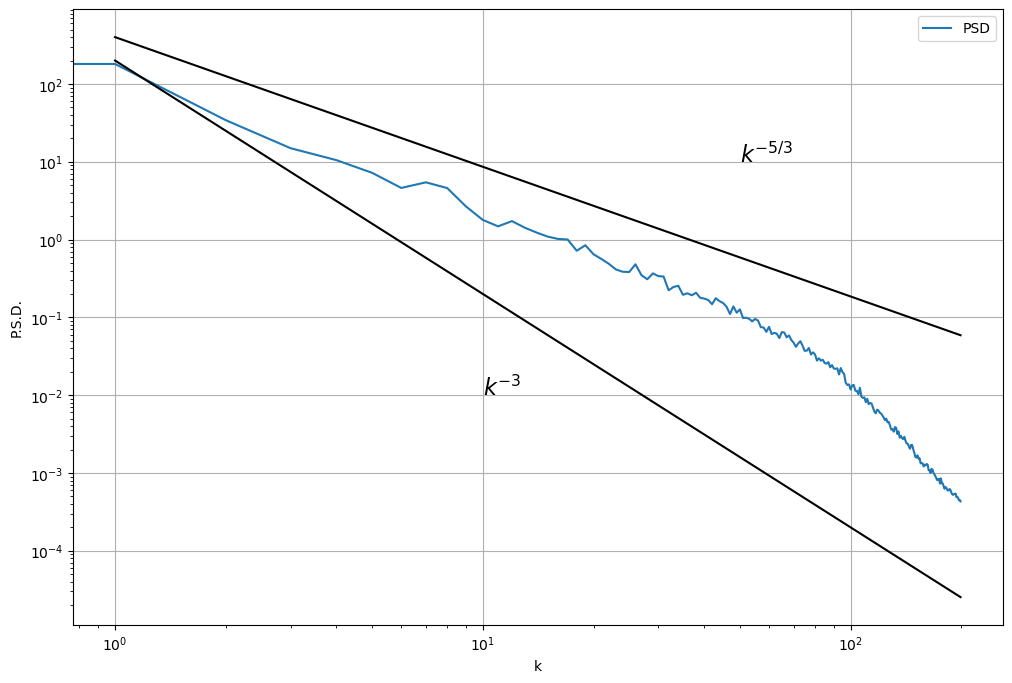

In [14]:
def spec2d(nx, kk, phi, hanning=True):
    
    # Windowing
    if hanning:
        han = np.sqrt(np.outer(np.hanning(uzoom.shape[0]),np.hanning(uzoom.shape[1])))
        phi = phi * han
        
    # FFT 2d
    hphi = np.abs(np.fft.fft2(phi))**2/(u.shape[0]*u.shape[1])
    
    # Azimuthal average
    spec = np.zeros((nx//2,))
    for i in range(nx//2):
        spec[i] = np.sum(hphi[(kk>=i) & (kk<(i+1))])
    return spec


def set_x_and_k(n, L):
    k = ((n//2+np.arange(n)) % n) - n//2
    return (np.arange(n)+0.5)*L/n, 2*np.pi*k/L

###

ny, nx = uzoom.shape
_, kx = set_x_and_k(nx, 2*np.pi)
_, ky = set_x_and_k(ny, 2*np.pi)
kkx, kky = np.meshgrid(kx, ky)
kk = np.sqrt(kkx**2 + kky**2)

###

h = spec2d(nx, kk, uzoom) +  spec2d(nx, kk, vzoom)

###

plt.figure(figsize=(12,8))

plt.loglog(h, label='PSD')

#plt.axis([1, 100, 1e-3, 1e4])
plt.grid()
k = np.arange(1.,nx//2)
plt.plot(k, 2e2 * k**(-3), color='k')
plt.plot(k, 4e2 * k**(-5./3), color='k') # the coefficient set the vertical position of the line
plt.text(50, 10, r'$k^{-5/3}$', fontsize=16)
plt.text(10, .01, r'$k^{-3}$', fontsize=16)
plt.legend()
plt.xlabel('k')
plt.ylabel('P.S.D.')



In [7]:
u.shape

(2001, 1602)

In [8]:
v.shape

(2002, 1601)